In [3]:
## Import library

import pandas as pd 
# import keras
import numpy as np
import matplotlib.pyplot as plt
from cleanlab.classification import CleanLearning
# import tensorflow as tf
# from tensorflow import keras
# from keras import backend as K
from cleanlab import *
from torch import nn
import torch as torch
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from cleanlab.filter import find_label_issues


In [4]:
## Load the datas 

fmnist_test = pd.read_csv('fashion-mnist_test.csv')
fmnist_train = pd.read_csv('fashion-mnist_train.csv')

In [5]:
## Sort datas in x and y 

label_fmnist_test = fmnist_test.iloc[:,0]
label_fmnist_train = fmnist_train.iloc[:,0]
fmnist_test = fmnist_test.iloc[:,1:]
fmnist_train = fmnist_train.iloc[:,1:]

In [47]:
##Our label is jsute a number,

label_fmnist_test.shape
Y_test = label_fmnist_test.to_numpy()
Y_test = Y_test.astype('int32')
# Y_test = torch.from_numpy(Y_test)
# print(Y_test)

In [7]:
## Normalize

normalized_fmnist_test = fmnist_test /255
normalized_fmnist_train = fmnist_train /255

In [8]:
## We then constructs our pictures 
fashion_test = np.array(normalized_fmnist_test)
fashion_test = fashion_test.reshape(len(fashion_test),1,28,28)
fashion_test = fashion_test.astype('float32')

fashion_train = np.array(normalized_fmnist_train)
fashion_train = fashion_train.reshape(len(fashion_train),1,28,28)
fashion_train = fashion_train.astype('float32')

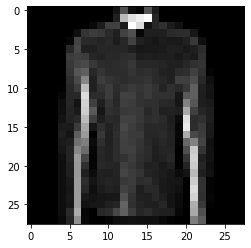

In [9]:
## Show if its good 
exemple_image = fashion_test[77,0,:,:]
plt.imshow(exemple_image, cmap='gray')

In [10]:
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [11]:
model_skorch = NeuralNetClassifier(ClassifierModule, max_epochs=50)

In [49]:
y = Y_test
X = fashion_test
y

array([0, 1, 2, ..., 8, 8, 1], dtype=int32)

In [ ]:

num_crossval_folds = 5
pred_probs = cross_val_predict(model_skorch, X, y,
                               cv=num_crossval_folds,
                               method='predict_proba')

In [50]:

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)

print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.8487


In [53]:
method = 'both'
ranked_label_issues = find_label_issues(y, pred_probs,filter_by=method,return_indices_ranked_by="self_confidence")

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print("Here are the indices of the top 15 most likely label errors:\n"
      f"{ranked_label_issues[:15]}")


Cleanlab found 752 label issues.
Here are the indices of the top 15 most likely label errors:
[5232 8042 8950 1178 2128 5076 1585 3591 2313 2224 4989 6512 1961 3558
 9330]


In [60]:
fashion_dico = {
    '0':'T-shirt/top',
    '1':'Trouser',
    '2':'Pullover',
    '3':'Dress',
    '4':'Coat',
    '5':'Sandal',
    '6':'Shirt',
    '7':'Sneaker',
    '8':'Bag',
    '9':'Ankle boot'
}
def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        fashion_id = str(y[id])
        plt.title(f"id: {id} \n label: {fashion_dico[fashion_id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

3
1
6
1
0


KeyError: '0'

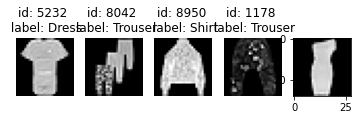

In [61]:
plot_examples(ranked_label_issues[range(15)], 3, 5)